<a href="https://colab.research.google.com/github/fpinell/hands_on_python_for_ds/blob/main/notebooks/phd/Lecture_2_Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning with Python

### PhD IMT Lucca 2024-2025

#### Fabio Pinelli
<a href="mailto:fabio.pinelli@imtlucca.it">fabio.pinelli@imtlucca.it</a><br/>
IMT School for Advanced Studies Lucca<br/>
2024/2025<br/>
May, 8 2025

# Lecture 2\*: Introduction to *unsupervised learning*
* Introduction
* K-means
* Other clustering methods
* One application on a real dataset and relative visualizations
* Dimensionality reduction (PCA) for clustering

\* with Lecture I mean "argument"

## Taxonomy of Machine Learning

-  Roughly speaking there are two main **categories** of ML tasks:

    1.  **Supervised Learning**: Given a set of **labeled** examples, **predict** the labels of _new and unseen_ examples
      + Classification
      + Regression
    2.  **Unsupervised Learning**: Given a set of examples, **find structure** in the data (e.g., _clusters_, _subspaces_, _manifolds_)

## What is and Why **clustering**?

- It is a set of methods used to find group of objects in such a way that objects in the same group (called a *cluster*) are more similar (**in some sense**) to each other than to those in other groups (clusters).

- Given a definition of distance (Euclidean?) (or *similarity*)

- Not all the data can have labels, but still you need to find *similar* objects in your dataset

- Can have a variety of applications:
  - Customer segmentation
  - Dimensionality reduction techniques as part of the ML process
  - Anomaly detection
  - Semi-supervised learning
  - etc

- We will explore a couple of methods:
  - K-means (and some of its variants)
  - DB-scan (so called density-based clustering)
  - Quickly some other methods (e.g. hierarchical)


## A quick introduction to **<code>scikit-learn</code>**:
- It is a powerful library to handle the entire ML pipeline
 - Data pre-processing
 - Modeling (training-test split/cross validation/grid search)
 - Error evaluation

- It is based on simple concepts:
 - fit
 - fit_transform
 - inverse_transform
 - predict

 - Scikit-learn is well integrated with many other Python libraries, such as <code>Matplotlib</code> and <code>plotly</code> for plotting, <code>NumPy</code> for array vectorization, <code>Pandas</code> dataframes, <code>SciPy</code>, and many more.


## Setup

A series of common commands to settle our working environment.

In [1]:
# Common imports
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Clustering

- It is a set of methods used to find group of objects in such a way that objects in the same group (called a *cluster*) are more similar (**in some sense**) to each other than to those in other groups (clusters).



## K-means
it aims to partition **$n$** observations into **$k$** clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or **cluster centroid**), serving as a prototype of the cluster.

Let's start by generating some blobs (it is a way to generate synthetic data with a sort of predefined shape).

We will explore the K-means procedure using a generated datasets using a scikit function *make_blobs*.


``` python
# Generate isotropic Gaussian blobs for clustering.

sklearn.datasets.make_blobs(n_samples=100, n_features=2, *, centers=None,
cluster_std=1.0, center_box=- 10.0, 10.0, shuffle=True, random_state=None,
return_centers=False)

```




In [ ]:
from sklearn.datasets import make_blobs

In [ ]:
#centers of our blobs of points
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
# standard deviation of our blobs to indicate the dispersion of each cluster
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [ ]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [ ]:
'''
Let's create the pandas dataframes so it might be easier for us to explore the data
'''
X = pd.DataFrame(X,columns=['feature1','feature2'])
y = pd.DataFrame(y,columns=['target'])


In [ ]:
print(X.shape)
print(y.shape)

print("How many clusters should we expect? {}".format(y.nunique()))

In [ ]:
'''"Which is the frequency of each cluster?'''
y.value_counts()


Now let's plot them:

In [ ]:
def plot_clusters(X, y=None,centers=None):
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=1)
    if centers is not None:
      plt.scatter(centers[:,0],centers[:,1],marker='x',c='red',s=40)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

In [ ]:
'''
plot centers and the relative blobs
'''
plt.figure(figsize=(8, 4))
plot_clusters(X,'blue',blob_centers)
# save_fig("blobs_plot")
plt.show()

### Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

``` python
class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init=10
max_iter=300, tol=0.0001, precompute_distances='deprecated', verbose=0,
random_state=None, copy_x=True, n_jobs='deprecated', algorithm='auto')
```


In [ ]:
from sklearn.cluster import KMeans

In [ ]:
'''
Find 5 clusters k = 5, clearly in this case, setting k is quite easy, since we already know the number of clusters.
Later, we will explore how to find the right number of clusters when it is 'not known'
'''

k = 5
# first we create the object kmeans with its parameters, then we fit (and predict)
# on the data
kmeans = KMeans(n_clusters=k, random_state=42,n_init=10)
y_pred = kmeans.fit_predict(X)

In [ ]:
# Each instance is assigned to one of the 5 clusters:

print('The shape of the predicted values is {}'.format(y_pred.shape))
print(y_pred)

In [ ]:

'''
All the labels are store in the attribute .labels_ of the kmeans object
'''
y_pred is kmeans.labels_

In [ ]:

kmeans.labels_

In [ ]:
'''
And the following 5 _centroids_ (i.e., cluster centers) were estimated:
'''
for i,c in enumerate(kmeans.cluster_centers_):
  print('Cluster {} with centroid ({},({})'.format(i,c[0],c[1]))

Defining functions let us to be more clean

In [ ]:
def compare_centroids(centroids_1,centroids_2):
  '''
  it plots the two arrays of centroids, the first one is for the real ones,
  the second for the ones estimated through clustering
  '''
  plt.scatter(centroids_1[:,0],centroids_1[:,1],marker='o',c='red',label='True')
  plt.scatter(centroids_2[:,0],centroids_2[:,1],marker='x',c='blue',label='Estimated')
  plt.legend(loc='best')

In [ ]:
'''
Check if the discovered centroids are close to the real ones. Not bad at all :-)
'''
compare_centroids(blob_centers,kmeans.cluster_centers_)

Note that the `KMeans` instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the _label_ of an instance is the index of the cluster that instance gets assigned to:

In [ ]:
kmeans.labels_

In [ ]:
'''
check if we clustered all the points in a correct way.
We create a new column in our dataset containing the cluster id, and we count the frequency
for each assigned label
'''
X['cluster_id'] = kmeans.labels_
X.cluster_id.value_counts()

### Decision Boundaries

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:

In [ ]:
def plot_data(X):
    plt.plot(X.iloc[:, 0], X.iloc[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))

    # Creating a DataFrame to ensure it uses the same features/columns
    df_temp = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X.columns)

    # Calling predict on the DataFrame
    Z = clusterer.predict(df_temp)

    Z = Z.reshape(xx.shape)
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [ ]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X[['feature1','feature2']])
# save_fig("voronoi_plot")
plt.show()

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good.

We can also *predict* new instances

In [ ]:
X_new = pd.DataFrame(data=np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]]),columns=['feature1','feature2'])
kmeans.predict(X_new)

### Hard Clustering _vs_ Soft Clustering

Rather than arbitrarily choosing the closest cluster for each instance, which is called _hard clustering_, it might be better measure the distance of each instance to all 5 centroids. This is what the `transform()` method does:

``` python
transform(X)

Transform X to a cluster-distance space.
```

In [ ]:
kmeans.transform(X_new)

You can verify that this is indeed the Euclidian distance between each instance and each centroid:

In [ ]:
'''
Compute the norm --> distance using
the numpy linear algebra
From the documentation: The NumPy linear algebra functions rely on BLAS and LAPACK
to provide efficient low level implementations of standard linear algebra algorithms.
'''

np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

### K-Means Algorithm

The K-Means algorithm is one of the fastest clustering algorithms, and also one of the simplest:
* First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.

The `KMeans` class applies an optimized algorithm by default. To get

---

the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1`and `algorithm="lloyd"`. These hyperparameters will be explained below.


`"auto"` and `"full"` are deprecated and they will be removed in Scikit-Learn 1.3. They are both aliases for `"lloyd"`

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [ ]:
'''
max_iter=1
max_iter=2
max_iter=3
'''

kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="lloyd", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="lloyd", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="lloyd", max_iter=3, random_state=0)
kmeans_iter1.fit(X[['feature1','feature2']])
kmeans_iter2.fit(X[['feature1','feature2']])
kmeans_iter3.fit(X[['feature1','feature2']])

And let's plot this:

In [ ]:
X

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X[['feature1','feature2']])
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X[['feature1','feature2']], show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X[['feature1','feature2']], show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X[['feature1','feature2']], show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X[['feature1','feature2']], show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X[['feature1','feature2']], show_ylabels=False)

# save_fig("kmeans_algorithm_plot")
plt.show()

### K-Means Variability

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

In [ ]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

In [ ]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="lloyd", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="lloyd", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X.iloc[:,[0,1]],
                          "Solution 1", "Solution 2 (with a different random init)")

# save_fig("kmeans_variability_plot")
plt.show()

### Inertia

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets, and therefore a precise concept of **error**.

But at least we can measure the distance between each instance and its centroid. This is the idea behind the _inertia_ metric:


It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster.


A good model is:
- one with low inertia AND
- a low number of clusters ( $k$ ).

In [ ]:
'''
attribute of the kmeans class inertia_
'''
kmeans.inertia_

As you can easily verify, inertia is the sum of the squared distances between each training instance and its closest centroid:

In [ ]:
X_dist = kmeans.transform(X.iloc[:,[0,1]])
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

The `score()` method returns the negative inertia. Why negative? Well, it is because a predictor's `score()` method must always respect the "_greater is better_" rule.

In [ ]:
kmeans.score(X.iloc[:,[0,1]])

### Multiple Initializations

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia. For example, here are the inertias of the two "bad" models shown in the previous figure:

In [ ]:
kmeans_rnd_init1.inertia_

In [ ]:
kmeans_rnd_init2.inertia_

As you can see, they have a higher inertia than the first "good" model we trained, which means they are probably worse.

When you set the `n_init` hyperparameter, Scikit-Learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets `n_init=10`.

In [ ]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="lloyd", random_state=2)
kmeans_rnd_10_inits.fit(X.iloc[:,[0,1]])

As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$).

In [ ]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X[['feature1','feature2']])
plt.show()

### K-Means++

Instead of initializing the centroids entirely randomly, it is preferable to initialize them using the following algorithm, proposed in a [2006 paper](https://goo.gl/eNUPw6) by David Arthur and Sergei Vassilvitskii:
* Take one centroid $c_1$, chosen uniformly at random from the dataset.
* Take a new center $c_i$, choosing an instance $\mathbf{x}_i$ with probability: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further away from already chosen centroids are much more likely be selected as centroids.
* Repeat the previous step until all $k$ centroids have been chosen.

The rest of the K-Means++ algorithm is just regular K-Means. With this initialization, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it is possible to reduce `n_init` considerably. Most of the time, this largely compensates for the additional complexity of the initialization process.

To set the initialization to K-Means++, simply set `init="k-means++"` (this is actually the default):

In [ ]:
# just to check the default parameters

KMeans()

In [ ]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X.iloc[:,[0,1]])
kmeans.inertia_

### Finding the optimal number of clusters

What if the number of clusters was set to a lower or greater value than 5?

In [ ]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X.iloc[:,[0,1]], "$k=3$", "$k=8$")
# save_fig("bad_n_clusters_plot")
plt.show()




Ouch, these two models don't look great. What about their inertias?

In [ ]:
print("k=3 inertia: {}".format(kmeans_k3.inertia_))
print("k=8 inertia: {}".format(kmeans_k8.inertia_))

No, we cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve:

In [ ]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X.iloc[:,[0,1]])
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [ ]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
# save_fig("inertia_vs_k_plot")
plt.show()

As you can see, there is an elbow at $k=4$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=4$ is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

In [ ]:
plot_decision_boundaries(kmeans_per_k[4-1], X[['feature1','feature2']])
plt.show()

Another approach is to look at the **_silhouette score_**
1. the mean _silhouette coefficient_ over all the instances.
2. An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where
  - $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_)
  - $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster).
3. The **silhouette coefficient** can vary between **-1** and **+1**:
  - a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters,
  - a coefficient close to 0 means that it is close to a cluster boundary
  - finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's plot the silhouette score as a function of $k$:

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
silhouette_score(X.iloc[:,[0,1]], kmeans.labels_)

In [ ]:
silhouette_scores = [silhouette_score(X.iloc[:,[0,1]], model.labels_)
                     for model in kmeans_per_k[1:]]

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
# save_fig("silhouette_score_vs_k_plot")
plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a _silhouette diagram_:

In [ ]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X.iloc[:,[0,1]], y_pred)

    padding = len(X.iloc[:,[0,1]]) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

As you can see, $k=5$ looks like the best option here, as all clusters are roughly the same size, and they all cross the dashed line, which represents the mean silhouette score.

### Limits of K-Means
 - set the number of $k$
 - run several times to avoid sub-optimal solutions
 - problem handling clusters with different density and not spherical shapes

In [ ]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [ ]:
X = pd.DataFrame(X,columns=['X1','X2'])


In [ ]:
plot_clusters(X)

In [ ]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

In [ ]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

# save_fig("bad_kmeans_plot")
plt.show()

### K-means on iris dataset

We repeat the tests performed on the synthetic dataset on a "real" one.



   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2
   target
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0


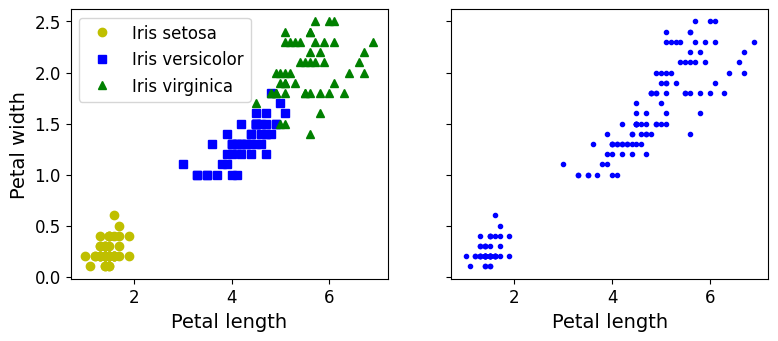

In [2]:
from sklearn.datasets import load_iris
'''
The Iris Dataset contains four features (length and width of sepals and petals)
of 50 samples of three species of Iris
(Iris setosa, Iris virginica and Iris versicolor)
'''
data = load_iris()
# X = data.data
# y = data.target
# data.target_names

'''
let's transform our data coming from sklearn in a pandas dataframe.
Notice that the method will work as well with initial data object
'''
df_iris = pd.DataFrame(data= np.c_[data['data'], data['target']],
                     columns= data['feature_names'] + ['target'])

df_iris.head()

'''
we select the features and the target column.
The target is used just for testing purposes
'''
features = [c for c in df_iris.columns if 'target' not in c]
target = ['target']
X = df_iris[features]
y = df_iris[target]
print(X.head())
print(y.head())


plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y['target']==0].iloc[:,2], X[y['target']==0].iloc[:,3], "yo", label="Iris setosa")
plt.plot(X[y['target']==1].iloc[:,2], X[y['target']==1].iloc[:,3], "bs", label="Iris versicolor")
plt.plot(X[y['target']==2].iloc[:,2], X[y['target']==2].iloc[:,3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X.iloc[:, 2], X.iloc[:, 3], c="b", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()

In [5]:
from sklearn.cluster import KMeans

In [6]:
'''
We test different values of k and we store the relative inertia values.
'''

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

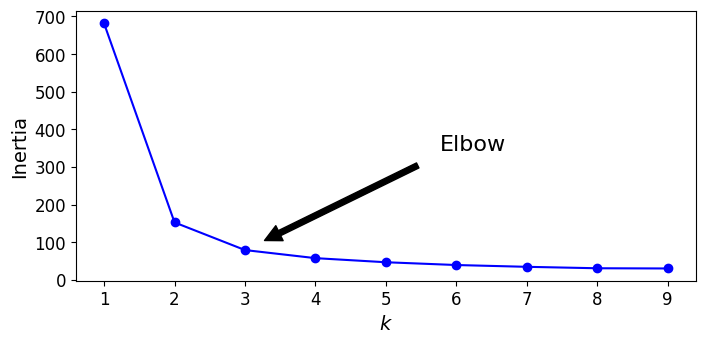

In [7]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(3, inertias[2]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
# plt.axis([1, 8.5, 0, 200])
# save_fig("inertia_vs_k_plot")
plt.show()

In [10]:
from sklearn.metrics import silhouette_score

In [11]:
'''
Here we compute the silhouette_score given the previous models
'''

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

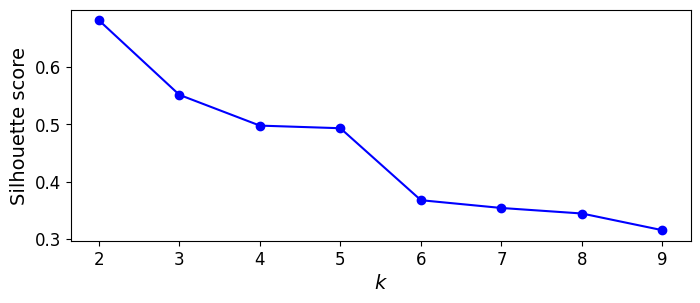

In [12]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
# save_fig("silhouette_score_vs_k_plot")
plt.show()

Saving figure silhouette_analysis_plot


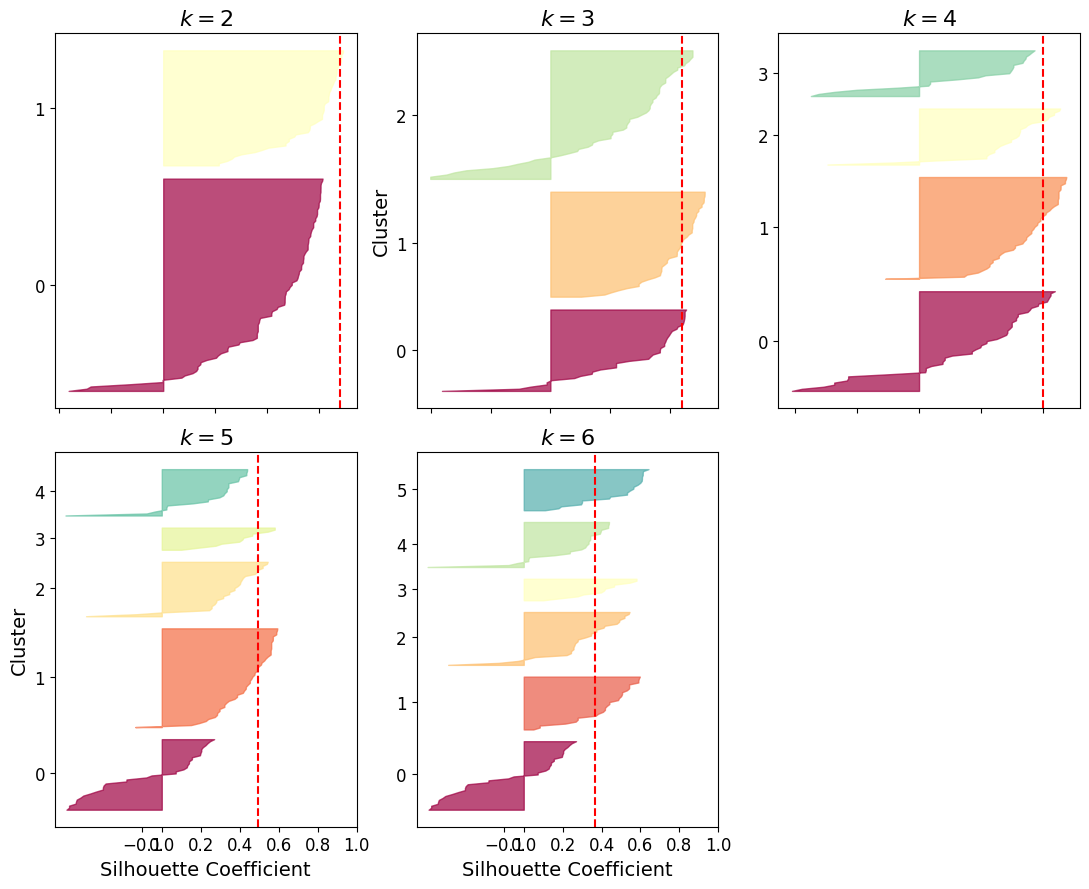

In [13]:
'''
same plot as before, we look how the silhouette_coefficients is distributed
across the clusters.
'''


from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5, 6):
    plt.subplot(2, 3, k - 1)

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X.iloc[:,[0,1]], y_pred)

    padding = len(X.iloc[:,[0,1]]) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

Let's plot how the clusters look like with two features (2D-plot)



<Axes: xlabel='petal length (cm)', ylabel='petal width (cm)'>

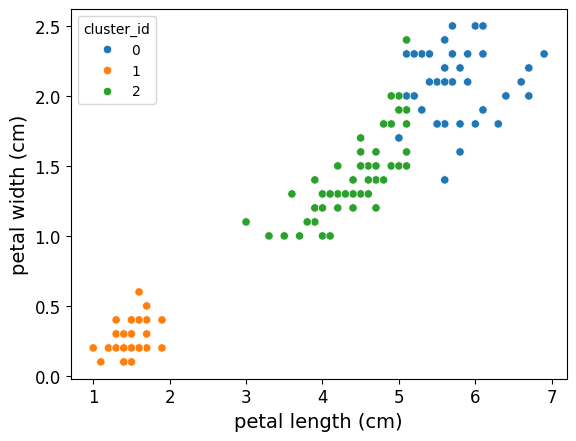

In [14]:
import seaborn as sns
kmeans = kmeans_per_k[2]
X['cluster_id'] = kmeans.labels_

'''
scatter plot in seaborn -- we can set a groupby column hue='' used to plot groups of data
'''
# we have 4 features, we plot two of them at the time
sns.scatterplot(data=X,x=X['petal length (cm)'],y=X['petal width (cm)'], hue='cluster_id', palette='tab10')



<Axes: xlabel='sepal length (cm)', ylabel='sepal width (cm)'>

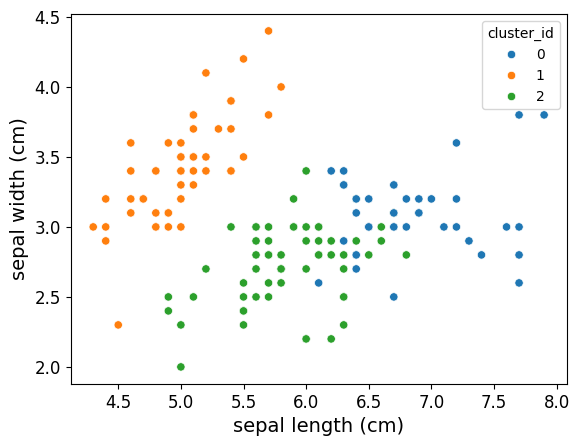

In [15]:

sns.scatterplot(data=X,x=X['sepal length (cm)'],y=X['sepal width (cm)'],hue='cluster_id', palette='tab10')


### Accelerated K-Means

The K-Means algorithm can be significantly accelerated by avoiding many unnecessary distance calculations: this is achieved by exploiting the triangle inequality (given three points A, B and C, the distance AC is always such that AC ≤ AB + BC) and by keeping track of lower and upper bounds for distances between instances and centroids (see this [2003 paper](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) by Charles Elkan for more details).

To use Elkan's variant of K-Means, just set `algorithm="elkan"`. Note that it does not support sparse data, so by default, Scikit-Learn uses `"elkan"` for dense data, and `"full"` (the regular K-Means algorithm) for sparse data.

In [ ]:
%timeit -n 50 KMeans(algorithm="elkan", random_state=42).fit(X.iloc[:,[1,2]])

In [ ]:
%timeit -n 50 KMeans(algorithm="full", random_state=42).fit(X.iloc[:,[1,2]])

There's no big difference in this case, as the dataset is fairly small.

### K-means at work

#### Web crawled data of company web-sites

We crawled the home-pages of around 370k firms in Italy.
For each home-page we tried to collect a series of signals in order to build eventually a new index able to capture the quality of company web sites, and then study if there is a relation between the performance of the companies and this new index.

The data has been collected in two phases: 1) we our own craler; 2) getting info through google lighthouse

For each home-page we gathered many features, but during our experiments we proved that only few of them are really useful, and some combinations of them:

- 'tested_url'
- 'linkedin'
- 'n_links'
- 'unique_links'
- 'links_in'
- 'links_out'
- 'unique_links_in'
- 'unique_links_out'
- 'y_m_wa'
- 'n_images'
- 'request_time'
- 'security_header'
- 'unknown'
- 'text_len'
- 'facebook'
- 'instagram'
- 'security_header_int'
- 'years_old'

Other information describing the firm in terms of size, industry, location are contained in another csv populated using AIDA database.

1. df with crawled features
2. df with google features
3. df with aida features



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install folium
!pip install geopandas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd # library to handle spatial data
import folium # library to generate maps
import seaborn as sns
from urllib.parse import urlparse
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
import json


#### Load the 3 above mentioned datasets:
 - crawled data
 - data gathered from google
 - orbis data

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/phd_hands_on/clustering_test/merged_web_full.csv',converters={'Codicefiscale':str})

In [ ]:
'''
Let's check some property of our first dataframe
'''
df.describe()


In [ ]:
df.info()


In [ ]:

print('The dataset contains {} rows and {} columns'.format(df.shape[0],df.shape[1]))
print('The columns contained in our first dataframe are:\n{}'.format( ',\n'.join('{}. {}'.format(i,c) for i,c in enumerate(df.columns)) ))


In [ ]:
'''
After several experiments we select only some of the columns of our dataset.
In this case we select the needed part of our dataframe using iloc
'''

df_sel = df.iloc[:,list(range(1,14))+[15,16,17,18,19,20,22,24,25]].copy()

In [ ]:

columns_to_be_selected = ['names']
df_sel = df[columns_to_selected].copy()

In [ ]:
'''
let's check the new shape, what do you expect?
There is another way to select only few columns?
'''
print('The new dataframe has this shape: {}'.format(df_sel.shape))
print('The old dataset instead... {}'.format(df.shape))

In [ ]:
'''
We want to generate new columns building some "stronger" indicator of the web-site quality
'''

df_sel['ratio_links'] = df_sel['unique_links']/df_sel['n_links']

df_sel['bad_images_ratio'] = df_sel['unknown']/df_sel['n_images']

df_sel['ratio_links_in'] = df_sel['unique_links_in']/df_sel['links_in']

df_sel['ratio_links_out'] = df_sel['unique_links_out']/df_sel['links_out']

df_sel['length_url'] = df_sel['original_url'].apply(lambda x:len(x))

In [ ]:
'''
Now are dataset has the following shape
'''
print('The new dataframe has this shape: {}'.format(df_sel.shape))

In [ ]:
'''
Let's load the dataframe that contains the information gathered using google lighthouse
'''

df_google = pd.read_csv('/content/drive/Shareddrives/phd_hands_on/clustering_test/google_features.csv',converters={'Codicefiscale':str})

In [ ]:
'''
Let's check some property of our second dataframe
'''
df_google.describe(include='all')


In [ ]:
print('The dataset contains {} rows and {} columns'.format(df_google.shape[0],df.shape[1]))
print('The columns contained in our first dataframe are:\n{}'.format( ',\n'.join('{}. {}'.format(i,c) for i,c in enumerate(df_google.columns)) ))


In [ ]:
'''
It could be useful and easier to have a single dataframe to handle
There is a common column between the two dataframes "Codicefiscale".
So we can merge the two dataframes using the common column.
In particular, we want all the firms that have both types of information --> inner join
'''
df_merged = pd.merge(df_sel,df_google,on='Codicefiscale',how='inner')

In [ ]:
'''
Let's have a look on how the shape of the df_merged dataframe is
'''
print('The dataset contains {} rows and {} columns'.format(df_merged.shape[0],df_merged.shape[1]))



In [ ]:
'''
Now the last dataframe, the one obtained from aida
For this one we select the columns by name.
What could we use instead of [] notation?
'''

df_orbis = pd.read_csv('/content/drive/Shareddrives/phd_hands_on/clustering_test/panel_aziende_crawled.csv',converters={'Codicefiscale':str,'ATECO2007codice':str})

orbis_columns = ['Codicefiscale','NUTS3','Classificazione per dimensione','NACE Rev. 2, sezione principale','Numero dipendenti\n2019','Città\nLocal Alphabet']


df_orbis = df_orbis[orbis_columns].copy()

In [ ]:
'''
we want to get only the ID from the NUTS3
'''
df_orbis['NUTS_ID'] = df_orbis.NUTS3.apply(lambda x: x.split(' - ')[0] if type(x) != float else x )

'''
And fill the NaN with a special value NULL
'''
df_orbis.fillna(value={'NACE Rev. 2, sezione principale':'NULL'},inplace=True)


'''
from the industry/sector/ateco we take only the first digit (that is a letter)
'''
df_orbis['macro_sector'] = df_orbis['NACE Rev. 2, sezione principale'].apply(lambda x: x.split(' - ')[0])

'''
Then we merged the two dataframes
'''
df_full = pd.merge(df_merged,df_orbis,on='Codicefiscale',how='left')

In [ ]:
print(df_full.shape)
print(df_merged.shape)

#### Aggregation

Performing the clustering on all the firms can be tricky. For now, keep it simple.

We aggregate the data by province (then by municipalities) and then we try to cluster the provinces and see if some spatial patterns emerge.

How we perform the aggregation at province level?

Pandas -- like <code>SQL</code> has the <code>groupby functionality</code>

For each "group" in the dataframe it can computes several aggregation functions.

In our case, the groups are the ....

In [ ]:
'''
The default behaviour of the groupby function is to use the groupby columns as index.
In this case, we set the input parameter as_index=False, to force the groupby to
use the groupby columns as other columns

Second, in general it is possible to specify the aggregation functions in several ways.
Using pd.NamedAgg let us decide the name of the columns containing the results of the aggregation.
'''


gb_df = df_full[df_full.NUTS_ID != 'ITF48'].groupby(['NUTS3','NUTS_ID'],as_index=False).agg(
        total = pd.NamedAgg(column='Codicefiscale', aggfunc='count'),
        instagrams = pd.NamedAgg(column='instagram', aggfunc='sum'),
        linkedins = pd.NamedAgg(column='linkedin', aggfunc='sum'),
        facebooks = pd.NamedAgg(column='facebook', aggfunc='sum'),

        mean_images = pd.NamedAgg(column='n_images', aggfunc='mean'),
        mean_bad_images = pd.NamedAgg(column='bad_images_ratio', aggfunc='mean'),
        mean_links = pd.NamedAgg(column='n_links', aggfunc='mean'),
        mean_links_in = pd.NamedAgg(column='links_in', aggfunc='mean'),
        mean_links_out = pd.NamedAgg(column='links_out', aggfunc='mean'),
        mean_ratio_links = pd.NamedAgg(column='ratio_links', aggfunc='mean'),
        mean_ratio_links_in = pd.NamedAgg(column='ratio_links_in', aggfunc='mean'),
        mean_ratio_links_out = pd.NamedAgg(column='ratio_links_out', aggfunc='mean'),
        mean_years_old = pd.NamedAgg(column='years_old', aggfunc='mean'),
        mean_security_header_int = pd.NamedAgg(column='security_header_int', aggfunc='mean'),
        mean_text_len = pd.NamedAgg(column='text_len', aggfunc='mean'),
        mean_request_time = pd.NamedAgg(column='request_time', aggfunc='mean'),
        mean_length_url = pd.NamedAgg(column='length_url', aggfunc='mean'),
        mean_accessibility = pd.NamedAgg(column='accessibility', aggfunc='mean'),
        mean_best_practices = pd.NamedAgg(column='best-practices', aggfunc='mean'),
        mean_performance = pd.NamedAgg(column='performance', aggfunc='mean'),
        mean_seo = pd.NamedAgg(column='seo', aggfunc='mean'),

        median_images = pd.NamedAgg(column='n_images', aggfunc='median'),
        median_request_time = pd.NamedAgg(column='request_time', aggfunc='median'),
        median_links = pd.NamedAgg(column='n_links', aggfunc='median'),
        median_links_in = pd.NamedAgg(column='links_in', aggfunc='median'),
        median_links_out = pd.NamedAgg(column='links_out', aggfunc='median'),
        median_years_old = pd.NamedAgg(column='years_old', aggfunc='median'),
        median_ratio_links = pd.NamedAgg(column='ratio_links', aggfunc='median'),
        median_ratio_links_in = pd.NamedAgg(column='ratio_links_in', aggfunc='median'),
        median_ratio_links_out = pd.NamedAgg(column='ratio_links_out', aggfunc='median'),
        median_bad_images = pd.NamedAgg(column='bad_images_ratio', aggfunc='median'),
        median_security_header_int = pd.NamedAgg(column='security_header_int', aggfunc='median'),
        median_text_len = pd.NamedAgg(column='text_len', aggfunc='median'),
        median_length_url = pd.NamedAgg(column='length_url', aggfunc='median'),
        median_accessibility = pd.NamedAgg(column='accessibility', aggfunc='median'),
        median_best_practices = pd.NamedAgg(column='best-practices', aggfunc='median'),
        median_performance = pd.NamedAgg(column='performance', aggfunc='median'),
        median_seo = pd.NamedAgg(column='seo', aggfunc='median'),
    )



gb_df['percentage_facebook'] = gb_df.facebooks/gb_df.total*100
gb_df['percentage_instagram'] = gb_df.instagrams/gb_df.total*100
gb_df['percentage_linkedin'] = gb_df.linkedins/gb_df.total*100

In [ ]:

gb_df.head()

In [ ]:
def province_rename(x):
    if x is not None:
        province_map = {
                    "Valle D'Aosta":'Aosta',
                    "Reggio Calabria": 'Reggio di Calabria',
                    "Reggio Emilia": "Reggio nell'Emilia",
                    "Forli-Cesena":"Forli'-Cesena",
                    "Ogliastra": "Sud Sardegna",
                    "Massa-Carrara": "Massa Carrara",
                    "Pesaro E Urbino": "Pesaro e Urbino"
                       }

        province = x.split('- ')[1]
        if province in province_map.keys():
            return province_map[province]
        return province
    return x

In [ ]:
gb_df['DEN_UTS'] = gb_df['NUTS3'].apply(lambda x: province_rename(x) )

In [ ]:
'''
To visualize data on maps we need to know the spatial polygons that describe the provinces.
This particular files are called shape files.
We can handle this kind of file using geopandas library.
It provides a series of spatial operations between dataframes containing
a geometry and a spatial system reference
'''
province_shape = gpd.read_file('/content/drive/Shareddrives/phd_hands_on/clustering_test/ProvCM01012021_g_WGS84.shp',encoding='utf-8')[['DEN_UTS','SIGLA','geometry']]


In [ ]:

province_shape.head()

In [ ]:
'''
Merge once again to add the geometry
'''

df_province_geom = pd.merge(gb_df,province_shape,on='DEN_UTS')


In [ ]:
'''
Let's recap
What we have in the dataset and how it looks like.
'''

df_province_geom.columns

In [ ]:
df_province_geom.shape

In [ ]:
df_province_geom.info()

We don't have null values, do you have an idea why?

In [ ]:
'''
And now some visualization.
We have a dataframe that contains several features per province.
The features, despite some ids, are all numerical columns,
therefore we can plot them and visualize, for instance, in a fancy map :-)
'''

# The function takes in input a dataframe, the column to be visualized
# and which column should be used for the geometry
# It returns a Folium map object


def map_df(df,column='percentage',column_gb = 'NUTS_ID'):
    gdf_nuts_geom = gpd.GeoDataFrame(df,geometry='geometry')
    gdf_nuts_geom.dropna(inplace=True)
    m = folium.Map((41.9027835,12.4963655),zoom_start=6)
    custom_scale = (df[column].quantile((0,0.33,0.66,1))).tolist()
    folium.Choropleth(
        geo_data=gdf_nuts_geom,
        data=gdf_nuts_geom,
        columns=[column_gb,column],
        key_on="feature.properties.{}".format(column_gb),
        threshold_scale=custom_scale,
        fill_color='YlGnBu',
        fill_opacity=1,
        line_opacity=0.5,
        legend_name="wills",
        smooth_factor=0,
        Highlight= True,
        line_color = "#0000",
        name = 'percentage',
        show=True,
        overlay=True,
        nan_fill_color = "White"
    ).add_to(m)
    style_function = lambda x: {'fillColor': '#ffffff',
                                'color':'#000000',
                                'fillOpacity': 0.1,
                                'weight': 0.1}

    highlight_function = lambda x: {'fillColor': '#000000',
                                    'color':'#000000',
                                    'fillOpacity': 0.50,
                                    'weight': 0.1}
    NIL = folium.features.GeoJson(
        data = gdf_nuts_geom,
        style_function=style_function,
        control=False,
        highlight_function=highlight_function,
        tooltip=folium.features.GeoJsonTooltip(
            fields=['NUTS3',column],
            aliases=['NUTS3',column],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
        )
    )
    m.add_child(NIL)
    return m

In [ ]:
m = map_df(df_province_geom,'percentage_instagram','NUTS3')

In [ ]:
m

In [ ]:
m.save('map_instagram.html')

#### Clustering, let's go for it

In [ ]:
'''
Some utility functions to color our beautiful maps
'''

def get_color(x):
    colors=['#9e0142', '#e95c47', '#fdbf6f', '#ffffbe', '#bfe5a0', '#54aead', '#5e4fa2']
    return colors[x]


In [ ]:

clustering_columns_mean_1 = [
 'mean_best_practices',
 'mean_seo',
 'mean_ratio_links_in',
 'mean_ratio_links_out',
 'mean_years_old',
 'mean_security_header_int',
 'mean_request_time',
 'mean_length_url',
 'percentage_facebook',
 'percentage_instagram',
 'percentage_linkedin']

# clustering_columns_mean_2 = ['mean_best_practices', 'mean_seo',]
# clustering_columns_median_1 = [       'median_accessibility', 'median_best_practices', 'median_performance',
#        'median_seo']

In [ ]:
'''
For plotting reasons, when we use Latex engine we can't use the _
so we need to handle it during the process -- nothing to worry about.
Then, we select the columns selected for the clustering
'''
gb_df.columns = [c.replace('-','_')for c in gb_df.columns]
df_clustering = gb_df[clustering_columns_mean_1].copy()

In [ ]:
'''
In order to define a distance over several features it is necessary to rescale them on a similar space.
Scikit provides a series of scaler, in this case we adopted the MinMax scaler.
'''

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_clustering)
print(type(scaled))
df_scaled = pd.DataFrame(scaled,columns=clustering_columns_mean_1)

In [ ]:
'''
We perform the elbow test as we did it before.
We test 10 k, and we plot the inertias
'''

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_scaled)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(3, inertias[2]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
# plt.axis([1, 8.5, 0, 200])
#     plt.savefig('clustering/elbow_{}.png'.format(name))
plt.show()

In [ ]:
n_clusters = 3

In [ ]:
km = kmeans_per_k[n_clusters-1]

gb_df['cluster_id'] = km.labels_

print(gb_df.cluster_id.value_counts())

gb_df.columns = [c.replace('_','-') if c in clustering_columns_mean_1 else c for c in gb_df.columns]

plt.figure(figsize=(15,7))

for i,c in enumerate(km.cluster_centers_):
    plt.plot(c,label='cluster {}'.format(i),marker='x',linewidth=3,color=get_color(i))

ticks = list(range(0,len(clustering_columns_mean_1),1))
columns = [c.replace('_','-') for c in clustering_columns_mean_1]
plt_labels = clustering_columns_mean_1[::1]
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel('Mean value', fontsize=24)
plt.xlabel('Clustering features', fontsize=24)

plt.grid()
plt.xticks(ticks=ticks,labels=plt_labels,rotation = 90)
plt.legend(loc='best',fontsize=18)
# plt.savefig('clustering/centroids_{}.png'.format(name))
plt.show()

In [ ]:
df_nuts_geom = pd.merge(gb_df,province_shape,on='DEN_UTS')

df_nuts_geom['rgba'] = df_nuts_geom.cluster_id.apply(lambda x: get_color(x).lower())

gdf_nuts_geom = gpd.GeoDataFrame(df_nuts_geom,geometry='geometry')
gdf_nuts_geom.dropna(inplace=True)

m = folium.Map((41.9027835,12.4963655),zoom_start=6)
folium.GeoJson(
    gdf_nuts_geom,
    style_function=lambda feature: {
        'fillColor': feature['properties']['rgba'],
        'color' : feature['properties']['rgba'],
        'weight' : 1,
        'fillOpacity' : 0.7,
        },
    tooltip=folium.GeoJsonTooltip(
        fields=['NUTS3','cluster_id'],
        aliases=['Provincia','Cluster'],
        localize=True
    )

    ).add_to(m)

# folium.map.CustomPane('labels').add_to(m)
#     folium.TileLayer('CartoDBPositronOnlyLabels',
#                      pane='labels').add_to(m)
#m.save('clustering/clustering_{}.html'.format(name))

In [ ]:
m

In [ ]:
'''
Well, if we want to test different sets of features, what we could to to authomatize the process??
'''
'''
We can define a function where we pass the columns to be used in the clustering
'''

def clustering(gb_df,columns,province_shape,name,n_clusters=3):
    gb_df.columns = [c.replace('-','_')for c in gb_df.columns]
    df_clustering = gb_df[columns].copy()

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_clustering)

    df_scaled = pd.DataFrame(scaled,columns=columns)

    kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_scaled)
                    for k in range(1, 10)]
    inertias = [model.inertia_ for model in kmeans_per_k]

    plt.figure(figsize=(8, 3.5))
    plt.plot(range(1, 10), inertias, "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Inertia", fontsize=14)
    plt.annotate('Elbow',
                 xy=(3, inertias[2]),
                 xytext=(0.55, 0.55),
                 textcoords='figure fraction',
                 fontsize=16,
                 arrowprops=dict(facecolor='black', shrink=0.1)
                )
    # plt.axis([1, 8.5, 0, 200])
#     plt.savefig('clustering/elbow_{}.png'.format(name))
    plt.show()

    km = kmeans_per_k[n_clusters-1]

    gb_df['cluster_id'] = km.labels_

    print(gb_df.cluster_id.value_counts())

    gb_df.columns = [c.replace('_','-') if c in columns else c for c in gb_df.columns]

    plt.figure(figsize=(20,10))

    for i,c in enumerate(km.cluster_centers_):
        plt.plot(c,label='cluster {}'.format(i),marker='x',linewidth=3,color=get_color(i))

    ticks = list(range(0,len(columns),1))
    columns = [c.replace('_','-') for c in columns]
    plt_labels = columns[::1]
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.ylabel('Mean value', fontsize=24)
    plt.xlabel('Clustering features', fontsize=24)

    plt.grid()
    plt.xticks(ticks=ticks,labels=plt_labels,rotation = 90)
    plt.legend(loc='best',fontsize=18)
    # plt.savefig('clustering/centroids_{}.png'.format(name))
    plt.show()

    df_nuts_geom = pd.merge(gb_df,province_shape,on='DEN_UTS')

    df_nuts_geom['rgba'] = df_nuts_geom.cluster_id.apply(lambda x: get_color(x).lower())

    gdf_nuts_geom = gpd.GeoDataFrame(df_nuts_geom,geometry='geometry')
    gdf_nuts_geom.dropna(inplace=True)

    m = folium.Map((41.9027835,12.4963655),zoom_start=6)
    folium.GeoJson(
        gdf_nuts_geom,
        style_function=lambda feature: {
            'fillColor': feature['properties']['rgba'],
            'color' : feature['properties']['rgba'],
            'weight' : 1,
            'fillOpacity' : 0.7,
            },
        tooltip=folium.GeoJsonTooltip(
            fields=['NUTS3','cluster_id'],
            aliases=['Provincia','Cluster'],
            localize=True
        )

        ).add_to(m)

    # folium.map.CustomPane('labels').add_to(m)
#     folium.TileLayer('CartoDBPositronOnlyLabels',
#                      pane='labels').add_to(m)
    #m.save('clustering/clustering_{}.html'.format(name))

    return m,gb_df


In [ ]:
m,clustered = clustering(gb_df,clustering_columns_mean_1,province_shape,3)

In [ ]:
clustering_columns_mean_1 = [
              'mean_best_practices',
              'mean_seo',
              'mean_ratio_links_in',
              'mean_ratio_links_out',
              'mean_years_old',
              'mean_security_header_int',
              'mean_request_time',
              'mean_length_url',
              'percentage_facebook',
              'percentage_instagram',
              'percentage_linkedin']

clustering_columns_mean_2 = [
                           'mean_bad_images',
                           'mean_ratio_links',
                           'mean_ratio_links_in',
                           'mean_ratio_links_out',
                           'mean_years_old',
                           'mean_security_header_int',
                           'mean_text_len',
                           'mean_request_time',
                           'mean_length_url',
                           'percentage_facebook',
                           'percentage_instagram',
                           'percentage_linkedin'
                          ]
clustering_columns_median_1 = [
                             'median_request_time',
                             'median_images',
                             'median_links',
                             'median_links_in',
                             'median_links_out',
                             'median_years_old',
                             'median_ratio_links',
                             'median_ratio_links_in',
                             'median_ratio_links_out',
                             'median_bad_images',
                             'median_security_header_int',
                             'median_text_len',
                             'median_length_url',
                             'percentage_facebook',
                             'percentage_instagram',
                             'percentage_linkedin'
                            ]
clustering_columns_median_2 = [
                             'median_request_time',
                             'median_years_old',
                             'median_ratio_links',
                             'median_ratio_links_in',
                             'median_ratio_links_out',
                             'median_bad_images',
                             'median_security_header_int',
                             'median_text_len',
                             'median_length_url',
                             'percentage_facebook',
                             'percentage_instagram',
                             'percentage_linkedin'
                            ]

In [ ]:
clustering_tests = {
    'mean_1':clustering_columns_mean_1,
    'mean_2':clustering_columns_mean_2,
    'median_1':clustering_columns_median_1,
    'median_2':clustering_columns_median_2,
}

In [ ]:
test_results = {}
for n in clustering_tests.keys():
    test_results[n] = clustering(gb_df,clustering_tests[n],province_shape,3)

In [ ]:
test_results["mean_1"][0]

In [ ]:

for k in test_results.keys():
  test_results[k][0]

In [ ]:
'''
We can repeat the process at different spatial granularity level --> municipalities
'''

comuni_shape = gpd.read_file('/content/drive/Shareddrives/phd_hands_on/clustering_test/Com01012021_g_WGS84.shp',encoding='utf-8')[['COMUNE','geometry']]

comuni_shape['lower'] = comuni_shape['COMUNE'].apply(lambda x: x.lower())

In [ ]:
gb_df = df_full[df_full.NUTS_ID != 'ITF48'].groupby(['Città\nLocal Alphabet'],as_index=False).agg(
        NUTS3 = pd.NamedAgg(column='NUTS3', aggfunc='first'),
        total = pd.NamedAgg(column='Codicefiscale', aggfunc='count'),
        instagrams = pd.NamedAgg(column='instagram', aggfunc='sum'),
        linkedins = pd.NamedAgg(column='linkedin', aggfunc='sum'),
        facebooks = pd.NamedAgg(column='facebook', aggfunc='sum'),

        mean_images = pd.NamedAgg(column='n_images', aggfunc='mean'),
        mean_bad_images = pd.NamedAgg(column='bad_images_ratio', aggfunc='mean'),
        mean_links = pd.NamedAgg(column='n_links', aggfunc='mean'),
        mean_links_in = pd.NamedAgg(column='links_in', aggfunc='mean'),
        mean_links_out = pd.NamedAgg(column='links_out', aggfunc='mean'),
        mean_ratio_links = pd.NamedAgg(column='ratio_links', aggfunc='mean'),
        mean_ratio_links_in = pd.NamedAgg(column='ratio_links_in', aggfunc='mean'),
        mean_ratio_links_out = pd.NamedAgg(column='ratio_links_out', aggfunc='mean'),
        mean_years_old = pd.NamedAgg(column='years_old', aggfunc='mean'),
        mean_security_header_int = pd.NamedAgg(column='security_header_int', aggfunc='mean'),
        mean_text_len = pd.NamedAgg(column='text_len', aggfunc='mean'),
        mean_request_time = pd.NamedAgg(column='request_time', aggfunc='mean'),
        mean_length_url = pd.NamedAgg(column='length_url', aggfunc='mean'),
        mean_accessibility = pd.NamedAgg(column='accessibility', aggfunc='mean'),
        mean_best_practices = pd.NamedAgg(column='best-practices', aggfunc='mean'),
        mean_performance = pd.NamedAgg(column='performance', aggfunc='mean'),
        mean_seo = pd.NamedAgg(column='seo', aggfunc='mean'),

        median_images = pd.NamedAgg(column='n_images', aggfunc='median'),
        median_request_time = pd.NamedAgg(column='request_time', aggfunc='median'),
        median_links = pd.NamedAgg(column='n_links', aggfunc='median'),
        median_links_in = pd.NamedAgg(column='links_in', aggfunc='median'),
        median_links_out = pd.NamedAgg(column='links_out', aggfunc='median'),
        median_years_old = pd.NamedAgg(column='years_old', aggfunc='median'),
        median_ratio_links = pd.NamedAgg(column='ratio_links', aggfunc='median'),
        median_ratio_links_in = pd.NamedAgg(column='ratio_links_in', aggfunc='median'),
        median_ratio_links_out = pd.NamedAgg(column='ratio_links_out', aggfunc='median'),
        median_bad_images = pd.NamedAgg(column='bad_images_ratio', aggfunc='median'),
        median_security_header_int = pd.NamedAgg(column='security_header_int', aggfunc='median'),
        median_text_len = pd.NamedAgg(column='text_len', aggfunc='median'),
        median_length_url = pd.NamedAgg(column='length_url', aggfunc='median'),

        median_accessibility = pd.NamedAgg(column='accessibility', aggfunc='median'),
        median_best_practices = pd.NamedAgg(column='best-practices', aggfunc='median'),
        median_performance = pd.NamedAgg(column='performance', aggfunc='median'),
        median_seo = pd.NamedAgg(column='seo', aggfunc='median')
    )

gb_df['percentage_facebook'] = gb_df.facebooks/gb_df.total*100
gb_df['percentage_instagram'] = gb_df.instagrams/gb_df.total*100
gb_df['percentage_linkedin'] = gb_df.linkedins/gb_df.total*100

In [ ]:

gb_df['lower'] = gb_df['Città\nLocal Alphabet'].apply(lambda x: x.lower())

In [ ]:

gb_df = gb_df[gb_df.total >= 10].copy()
gb_df.reset_index(inplace=True)

In [ ]:

clustering_columns_mean_1 = [
 'mean_best_practices',
 'mean_seo',
 'mean_ratio_links_in',
 'mean_ratio_links_out',
 'mean_years_old',
 'mean_security_header_int',
 'mean_request_time',
 'mean_length_url',
 'percentage_facebook',
 'percentage_instagram',
 'percentage_linkedin']

columns_to_scale_mean_1 = [
 'mean_ratio_links_in',
 'mean_ratio_links_out',
 'mean_years_old',
 'mean_security_header_int',
 'mean_request_time',
 'mean_length_url',
 'percentage_facebook',
 'percentage_instagram',
 'percentage_linkedin','mean_best_practices',
 'mean_seo',
]
columns_not_scaled = [

]

In [ ]:
gb_df.columns = [c.replace('-','_') for c in gb_df.columns]

columns = clustering_columns_mean_1
columns_to_scale = columns_to_scale_mean_1
df_clustering = gb_df[columns].copy()

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_clustering[columns_to_scale])

df_scaled = pd.DataFrame(scaled,columns=columns_to_scale)
df_scaled = pd.merge(df_scaled,df_clustering[columns_not_scaled],left_index=True, right_index=True)

In [ ]:
columns = clustering_columns_mean_1
df_clustering = gb_df[columns].copy()

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_clustering)

df_scaled = pd.DataFrame(scaled,columns=columns)

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_scaled)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(3, inertias[2]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
# plt.axis([1, 8.5, 0, 200])
#     plt.savefig('clustering/elbow_{}.png'.format(name))
plt.show()

In [ ]:
km = kmeans_per_k[2]

gb_df['cluster_id'] = km.labels_

print(gb_df.cluster_id.value_counts())

gb_df.columns = [c.replace('_','-') if c in columns else c for c in gb_df.columns]

plt.figure(figsize=(10,7))

for i,c in enumerate(km.cluster_centers_):
    plt.plot(c,label='cluster {}'.format(i),marker='x',linewidth=3,color=get_color(i))

ticks = list(range(0,len(columns),1))
columns = [c.replace('_','-') for c in columns]
plt_labels = columns[::1]
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.ylabel('Mean value', fontsize=32)
plt.xlabel('Clustering features', fontsize=32)

plt.grid()
plt.xticks(ticks=ticks,labels=plt_labels,rotation = 90)
plt.legend(loc='best',fontsize=24)
# plt.savefig('clustering/centroids_{}.png'.format(name))
plt.show()



In [ ]:
gb_df['lower'] = gb_df['Città\nLocal Alphabet'].apply(lambda x: x.lower())

In [ ]:
df_nuts_geom = pd.merge(gb_df,comuni_shape,on='lower')

df_nuts_geom['rgba'] = df_nuts_geom.cluster_id.apply(lambda x: get_color(x).lower())


In [ ]:
# clusters = [2]
gdf_nuts_geom = gpd.GeoDataFrame(df_nuts_geom,geometry='geometry')
gdf_nuts_geom.dropna(inplace=True)
# gdf_nuts_geom = gdf_nuts_geom[gdf_nuts_geom.cluster_id.isin(clusters)]
m = folium.Map((41.9027835,12.4963655),zoom_start=6)
folium.GeoJson(
    gdf_nuts_geom,
    style_function=lambda feature: {
        'fillColor': feature['properties']['rgba'],
        'color' : feature['properties']['rgba'],
        'weight' : 0.7,
        'fillOpacity' : 0.5,
        },
    tooltip=folium.GeoJsonTooltip(
        fields=['lower','cluster_id','total'],
        aliases=['Comune','Cluster','Totale imprese'],
        localize=True
    )

    ).add_to(m)

# folium.map.CustomPane('labels').add_to(m)
# #     folium.TileLayer('CartoDBPositronOnlyLabels',
# #                      pane='labels').add_to(m)

In [ ]:
m

## DBSCAN Density-Based Spatial Clustering of Applications with Noise

It is a density-based clustering non-parametric algorithm (you don't need to specify the number of $k$ clusters to extract): given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away). DBSCAN is one of the most common clustering algorithms and also most cited in scientific literature.

How it works:

1. For each instance it counts how many instances are located withing a small distance **$\epsilon$** from it. The region is called the instance's **$\epsilon$-neighborhood**
2. If an instance has at least **min_sample** instances in its **$\epsilon$-neighborhood**, then it is considered a *core instance*
3. All the instances in the neighborhood of a core instance belong to the same cluster
4. Any instance that is not a core instance and does not have one in its neighborhood is considered as **anomaly** (noise)


```python
class sklearn.cluster.DBSCAN(eps=0.5, *, min_samples=5, metric='euclidean',
metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
```

Further details [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)


In [16]:
from sklearn.cluster import DBSCAN

'''
two main parameters: eps and min_samples.
'''

dbscan = DBSCAN(eps=0.45, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.45)

In [17]:
labels = pd.Series(dbscan.labels_)

In [18]:
np.unique(labels)

array([-1,  0,  1,  2])

In [19]:
'''
which are the labels of our clusters?
'''
labels.value_counts()

,count
1,52
0,48
-1,26
2,24


### How can we find the best value, for instance, for $\epsilon$

In [20]:
#run of dbscan with different eps parameter

dbscan_per_eps = [DBSCAN(eps=eps, min_samples=5).fit(X)
                for eps in np.arange(0.1,0.5,0.05)]


In [21]:
'''
also for dbscan we can compute the silhouette.
'''
silhouette_scores_dbs = [silhouette_score(X, model.labels_)
                     for model in dbscan_per_eps if len(set(model.labels_)) > 1]

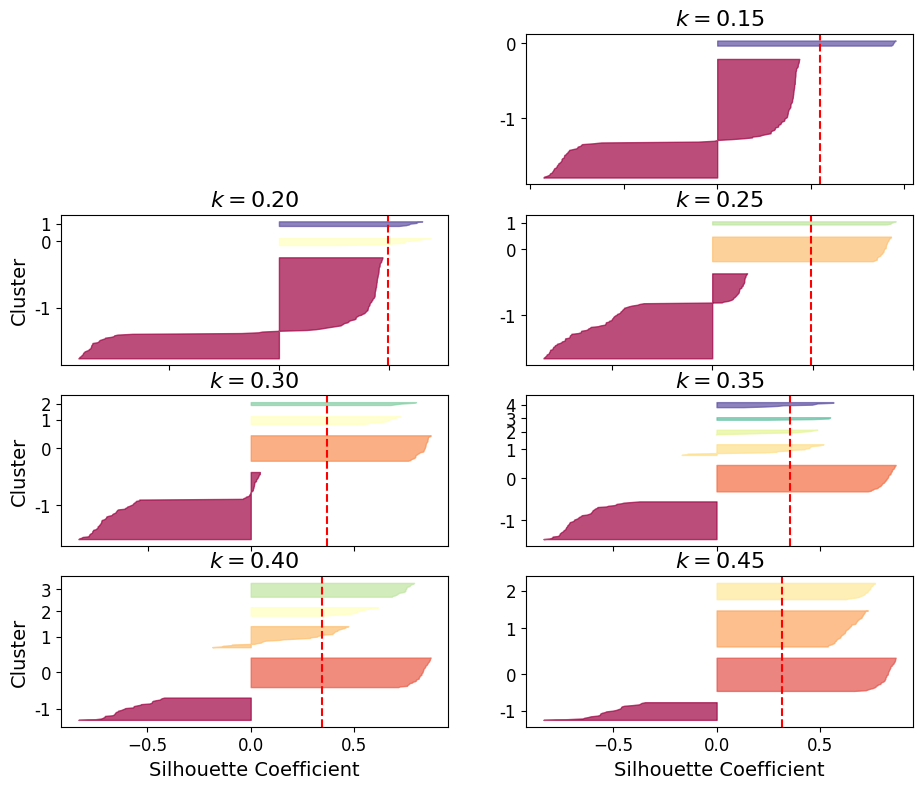

In [22]:
'''
Silhouette plots also for dbscan
'''
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import math

plt.figure(figsize=(11, 9))

for i, eps in enumerate(np.arange(0.1,0.5,0.05)):
    y_pred = dbscan_per_eps[i].labels_
    if len(set(y_pred))>1:

      n_cols = 2
      n_rows = math.ceil(len(dbscan_per_eps)/n_cols)
      plt.subplot(n_rows, n_cols, i+1)

      silhouette_coefficients = silhouette_samples(X, y_pred)

      padding = len(X) // 10
      pos = padding
      ticks = []
      for j in [-1]+list(range(i)):
          coeffs = silhouette_coefficients[y_pred == j]
          coeffs.sort()

          color = mpl.cm.Spectral((j+1) / (i))
          plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                            facecolor=color, edgecolor=color, alpha=0.7)
          ticks.append(pos + len(coeffs) // 2)
          pos += len(coeffs) + padding

      plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
      plt.gca().yaxis.set_major_formatter(FixedFormatter([-1]+list(range(i))))
      if i in (2, 4, 6):
          plt.ylabel("Cluster")

      if i in (6, 7):
          # plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
          plt.xlabel("Silhouette Coefficient")
      else:
          plt.tick_params(labelbottom=False)

      plt.axvline(x=silhouette_scores[i], color="red", linestyle="--")
      plt.title("$k={:.2f}$".format(eps), fontsize=16)

# save_fig("silhouette_analysis_plot")
plt.show()

The algorithm is based on regions with higher density, such as regions where the distance betweeen the objects is smaller.

Therefore, another way to properly set a good value for $\epsilon$ is to look at the distribution of the distances of closest neighboors.  

Let's do it.

In [23]:
# we take the distance between the 2 closest points for each object

from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

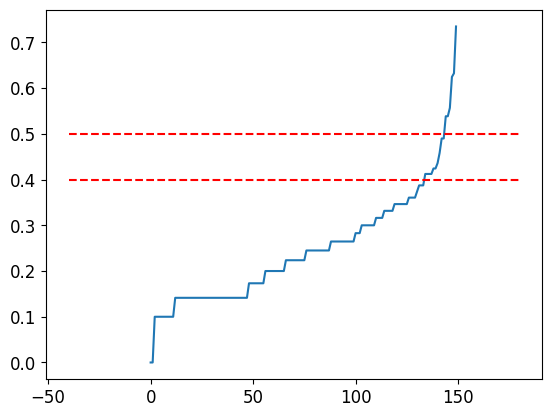

In [24]:
# plot sorted distances and find where there is a elbow (again)
# in this case is aro

distances = np.sort(distances, axis=0)
distances_plot = distances[:,1]
plt.plot(distances_plot)
plt.hlines(0.4,-40,180,linestyles='--',colors='red')
plt.hlines(0.5,-40,180,linestyles='--',colors='red')

<Axes: xlabel='petal length (cm)', ylabel='petal width (cm)'>

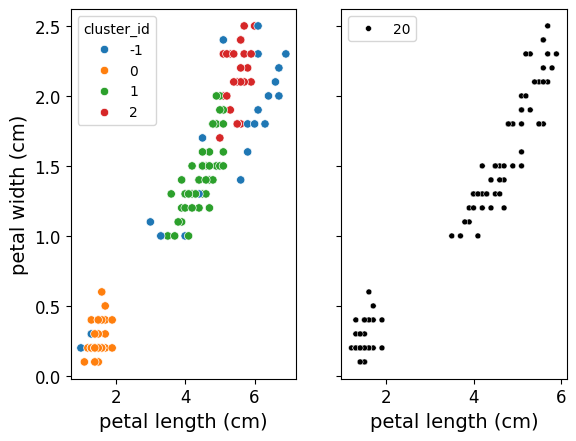

In [25]:
import seaborn as sns
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.45,min_samples=5)
dbscan.fit(X)
clusters = dbscan.labels_

X['cluster_id'] = dbscan.labels_
figure, axes = plt.subplots(nrows=1,ncols=2,sharey=True)
sns.scatterplot(data=X,x=X['petal length (cm)'],y=X['petal width (cm)'], hue='cluster_id', palette='tab10',ax=axes[0])
core_points = X[X.index.isin(dbscan.core_sample_indices_)]
sns.scatterplot(data=core_points,x=core_points['petal length (cm)'],y=core_points['petal width (cm)'],size=20,markers=['x'],color='black',ax=axes[1])

## Other Clustering Algorithms

### Agglomerative Clustering

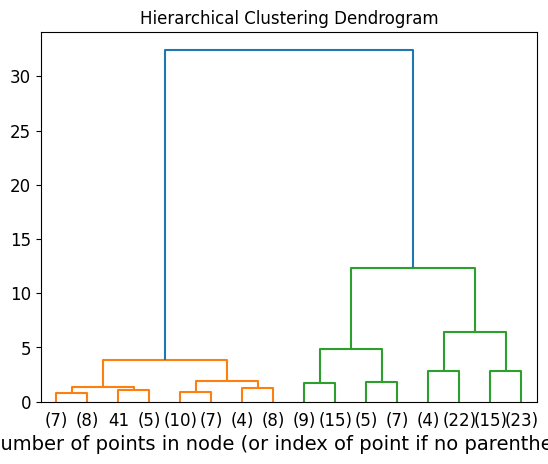

In [26]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
X = iris.data

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Spectral Clustering

In [ ]:
from sklearn.cluster import SpectralClustering

In [ ]:
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

In [ ]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

In [ ]:
np.percentile(sc1.affinity_matrix_, 95)

In [ ]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

In [ ]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()


# Dimensionality reduction

- Use a dimensionality reduction algorithm to speed-up the application of a clustering algorithm obtaining similar results

## *Principal Component Analysis (PCA)*

``` python
class sklearn.decomposition.PCA(n_components=None, *, copy=True,
whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto',
random_state=None)
```

- Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD

[PCA scikit-learn page](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)



In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [ ]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)


In [ ]:
X.shape

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

#find the number of components needed to cover the 0.95 of the variance

d = np.argmax(cumsum >= 0.95) + 1

In [ ]:
print('How many components do we need to have 95% of the variance? {}'.format(d))

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
# save_fig("explained_variance_plot")
plt.show()


In [ ]:
'''
the n_components parameter can take values with different semantics:
- an integer that corresponds to the number of components
- a float in the interval (0,1) as the explained variance required and the number
of components it is determined automatically by the PCA class
'''

# example of the first use
pca = PCA(n_components=0.99)
X_reduced = pca.fit_transform(X_train)

print('How many components? '.format(pca.n_components_))

print('Explained variance {:.2f}'.format(np.sum(pca.explained_variance_ratio_)))

# example of the second use
pca = PCA(n_components=331)

#remember scikit transform, fit, and inverse_transform
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

# save_fig("mnist_compression_plot")



In [ ]:
X_reduced_pca = X_reduced

from sklearn.cluster import KMeans

kmeans_reduced = KMeans(n_clusters=10, random_state=42)
kmeans_reduced.fit(X_reduced_pca)

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X_train)

def plot_clusters(faces, labels, n_cols=5):
#     inversed = pca.inverse_transform(faces)
#     print(inversed.shape)
    faces = faces.reshape(-1,28, 28)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in (set(kmeans_reduced.labels_)):
    print("Cluster", cluster_id)
    in_cluster = kmeans_reduced.labels_==cluster_id
    digits = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_clusters(digits[:10,:], labels[:10])


## How can I compute the most relevant label for each cluster?
## add a column with the right label and the cluster_id
## compute the value counts or use the groupby function (we didn't see it)

## how we can compute the differences between the results obtained on the reduced
## w.r.t. the real ones?




In [ ]:
for cluster_id in (set(kmeans.labels_)):
    print("Cluster", cluster_id)
    in_cluster = kmeans.labels_==cluster_id
    digits = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_clusters(digits[:10,:], labels[:10])


- It is possible to speed-up the process setting the ```svd_solver``` parameter to ```randomized```.

- It uses a stochastic algorithm that quickly finds an approximation of the first *d* principal components.


In [ ]:
pca = PCA(n_components=311,svd_solver="randomized",random_state=42)
X_reduced = pca.fit_transform(X_train)

print('Number of components {}'.format(pca.n_components_))

print('The total explained variance is {:.2f}'.format(np.sum(pca.explained_variance_ratio_)))

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

# save_fig("mnist_compression_plot")
